**Общая информация**

**Срок сдачи:** 29 марта 2021, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_20newsgroups

from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.metrics import accuracy_score, pairwise_distances

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

%load_ext pycodestyle_magic
%matplotlib inline

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
%%flake8

class MyKNeighborsClassifier(BaseEstimator):

    def __init__(self, n_neighbors=5, algorithm='brute'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm

    def cross_validation_predict(self, X, y, metric='euclidean',
                                 nearest_neighbor_max=10, n_folds=3):
        self.X_cross = X
        self.y_cross = np.asarray(y, dtype='int32')
        self.n_cross = nearest_neighbor_max
        dependence = np.zeros(self.n_cross)
        kf = KFold(n_folds, shuffle=True)
        for train, test in kf.split(self.X_cross, self.y_cross):
            dist = pairwise_distances(
                self.X_cross[test],
                self.X_cross[train],
                metric=metric
            )
            indices = np.argpartition(
                dist,
                np.arange(self.n_cross),
                axis=1
            )[:, :self.n_cross]
            for i in np.arange(nearest_neighbor_max):
                k_nearest = self.y_cross[train][indices[:, :i + 1]]
                prediction = np.zeros(test.shape[0], dtype='int32')
                for j in np.arange(test.shape[0]):
                    prediction[j] = np.bincount(k_nearest[j]).argmax()
                tmp = accuracy_score(self.y_cross[test], prediction)
                dependence[i] += tmp
        dependence /= n_folds
        return dependence

    def fit(self, X, y):
        self.X_train = X
        self.y_train = np.asarray(y, dtype='int32')
        if self.algorithm == 'kd_tree':
            self.kd_tree = KDTree(self.X_train)

    def predict(self, X, metric='euclidean'):

        if self.algorithm == 'brute':
            dist = pairwise_distances(X, self.X_train, metric=metric)
            indices = np.argpartition(
                dist,
                np.arange(self.n_neighbors),
                axis=1
            )[:, :self.n_neighbors]
            k_nearest = y_train[indices]
            prediction = np.zeros(X.shape[0], dtype='int32')
            for i in np.arange(X.shape[0]):
                prediction[i] = np.bincount(k_nearest[i]).argmax()
            return prediction

        elif self.algorithm == 'kd_tree':
            dist, indices = self.kd_tree.query(X, k=self.n_neighbors)
            k_nearest = self.y_train[indices]
            prediction = np.zeros(X.shape[0], dtype='int32')
            for i in np.arange(X.shape[0]):
                prediction[i] = np.bincount(k_nearest[i]).argmax()
            return prediction

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs(accuracy_score(y_test, my_clf_pred) - accuracy_score(y_test, sklearn_pred)) < 0.005

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [8]:
%time clf.fit(X_train, y_train)

CPU times: user 1.42 ms, sys: 363 µs, total: 1.78 ms
Wall time: 1.45 ms


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [9]:
%time my_clf.fit(X_train, y_train)

CPU times: user 0 ns, sys: 76 µs, total: 76 µs
Wall time: 64.6 µs


In [10]:
%time clf.predict(X_test)

CPU times: user 3.01 ms, sys: 783 µs, total: 3.79 ms
Wall time: 2.75 ms


array([2, 1, 2, 0, 1, 1, 2, 1, 0, 0, 0, 2, 2, 0, 1])

In [11]:
%time my_clf.predict(X_test)

CPU times: user 2.24 ms, sys: 588 µs, total: 2.82 ms
Wall time: 3.9 ms


array([2, 1, 2, 0, 1, 1, 2, 1, 0, 0, 0, 2, 2, 0, 1], dtype=int32)

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [12]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [14]:
%time clf.fit(X_train, y_train)

CPU times: user 0 ns, sys: 1.72 ms, total: 1.72 ms
Wall time: 1.81 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [15]:
%time my_clf.fit(X_train, y_train)

CPU times: user 276 µs, sys: 74 µs, total: 350 µs
Wall time: 329 µs


In [16]:
%time clf.predict(X_test)

CPU times: user 5.43 ms, sys: 354 µs, total: 5.79 ms
Wall time: 4.35 ms


array([2, 0, 1, 1, 0, 2, 2, 2, 0, 1, 0, 0, 2, 1, 1])

In [17]:
%time my_clf.predict(X_test)

CPU times: user 891 µs, sys: 239 µs, total: 1.13 ms
Wall time: 747 µs


array([2, 0, 1, 1, 0, 2, 2, 2, 0, 1, 0, 0, 2, 1, 1], dtype=int32)

In [18]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs(accuracy_score(y_test, my_clf_pred) - accuracy_score(y_test, sklearn_pred)) < 0.005

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [19]:
newsgroups = fetch_20newsgroups(subset='train', remove=['headers','footers', 'quotes'])

In [20]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [21]:
X_train, y_train = CountVectorizer(max_features=71000).fit_transform(data), target
X_train.shape, y_train.shape

((11314, 71000), (11314,))

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

array([0.21601623, 0.18605354, 0.18242944, 0.1841971 , 0.18154548,
       0.18384346, 0.18799755, 0.18702559, 0.18861654, 0.1925937 ])

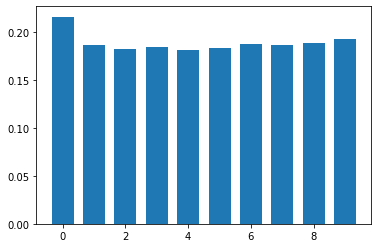

In [22]:
my_clf = MyKNeighborsClassifier()
res = my_clf.cross_validation_predict(X_train, y_train)
plt.bar(np.arange(res.shape[0]), res, width=0.7)
res

Напишите метод, позволяющий найти оптимальное количество ближайших соседей (дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

array([0.60155529, 0.5630191 , 0.5740684 , 0.57397973, 0.57689684,
       0.57583647, 0.57389183, 0.57212439, 0.56991469, 0.56964955])

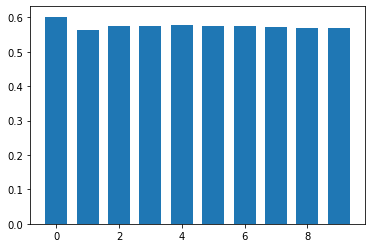

In [23]:
X_train = TfidfVectorizer(max_features=71000).fit_transform(data)
res = my_clf.cross_validation_predict(X_train, y_train, metric='cosine')
plt.bar(np.arange(res.shape[0]), res, width=0.7)
res

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [24]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [25]:
my_clf = MyKNeighborsClassifier(9)
my_clf.fit(X_train, y_train)
X_test = TfidfVectorizer(max_features=71000).fit_transform(newsgroups['data'])
y_test = newsgroups['target']
accuracy_score(y_test, my_clf.predict(X_test, metric='cosine'))

0.06492299522039299

Метрика **TF-IDF** применима для поиска в рамках одной группы документов, т.к. в `fit` и `predict` были переданы результаты 2х вызовов `TfidfVectorizer` от разных групп текстов, то фичи *X_train* и *X_test* не имеют друг с другом ничего общего.
Поэтому `accuracy_score` выдает ужасный показатель на предикте с лучшей моделью